In [4]:
import pandas as pd
url = 'https://drive.google.com/uc?id=1q2zjGbjNQLphJ5L-v6-Hgjy_vnNZVEvN'
df_cleaned_modified = pd.read_csv(url)
df_cleaned_modified
df_cleaned_modified = df_cleaned_modified.drop('Unnamed: 0', axis=1)

In [6]:
X = df_cleaned_modified.select_dtypes(include=['float64', 'int64']).drop('class', axis=1)
y = df_cleaned_modified['class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [36]:
#Нормализуем данные
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
#Сокращаем количество признаков с помощью PCA
from sklearn.decomposition import PCA
pca = PCA(svd_solver='full')
pca.fit(X_train)
cumulative_variance = pca.explained_variance_ratio_.cumsum()
M = (cumulative_variance > 0.95).argmax() + 1

print("Minimum number of principal components (M):", M)

X_train_pca_m = pca.transform(X_train)[:, :M]
X_test_pca_m = pca.transform(X_test)[:, :M]

Minimum number of principal components (M): 7


In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Тренируем модель
model_m = GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, random_state=23, max_depth=2)
model_m.fit(X_train_pca_m, y_train)
y_pred_m = model_m.predict(X_test_pca_m)

report_m = classification_report(y_test, y_pred_m)
confusion_mat_m = confusion_matrix(y_test, y_pred_m)
accuracy_m = accuracy_score(y_test, y_pred_m)

print("Classification Report:\n", report_m)
print("Confusion Matrix:\n", confusion_mat_m)
print("Model Accuracy:", accuracy_m)

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       115
           1       0.70      0.74      0.72        19

    accuracy                           0.92       134
   macro avg       0.83      0.84      0.83       134
weighted avg       0.92      0.92      0.92       134

Confusion Matrix:
 [[109   6]
 [  5  14]]
Model Accuracy: 0.917910447761194


In [10]:
pca = PCA(svd_solver='full')
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, random_state=23, max_depth=2)
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion_mat)
print("Model Accuracy:", accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94       115
           1       0.61      0.74      0.67        19

    accuracy                           0.90       134
   macro avg       0.78      0.83      0.80       134
weighted avg       0.91      0.90      0.90       134

Confusion Matrix:
 [[106   9]
 [  5  14]]
Model Accuracy: 0.8955223880597015


In [12]:
#рассмотрим различные модели и оценим их точность
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score

dec_tree = BaggingClassifier(
    DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5,
    max_features=0.5,
    bootstrap=False,
  random_state=42)
dec_tree.fit(X_train_pca_m, y_train)

y_pred = dec_tree.predict(X_test_pca_m)

report_dc = classification_report(y_test,y_pred)
conf_mat_dc = confusion_matrix(y_test,y_pred)
accuracy_dc = accuracy_score(y_test,y_pred)

print(report_dc)
print(conf_mat_dc)
print(accuracy_dc)
f1_dc = round(f1_score(y_test, y_pred), 3)
print(f1_dc)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       115
           1       0.62      0.42      0.50        19

    accuracy                           0.88       134
   macro avg       0.76      0.69      0.72       134
weighted avg       0.87      0.88      0.87       134

[[110   5]
 [ 11   8]]
0.8805970149253731
0.5


In [13]:
#Рассмотрим метод RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf1 = rf_model.predict(X_test)

report_rf = classification_report(y_test,y_pred_rf1)
conf_mat_rf = confusion_matrix(y_test,y_pred_rf1)
accuracy_rf = accuracy_score(y_test,y_pred_rf1)

print(report_rf)
print(conf_mat_rf)
print(accuracy_rf)

f1_lr = round(f1_score(y_test, y_pred_rf1), 3)
print(f1_lr)

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       115
           1       0.70      0.74      0.72        19

    accuracy                           0.92       134
   macro avg       0.83      0.84      0.83       134
weighted avg       0.92      0.92      0.92       134

[[109   6]
 [  5  14]]
0.917910447761194
0.718


In [14]:
#Рассмотрим метод KNeigborsClassifier и определим лучшую из 3 метрик
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

classifier_kn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 3)

param_grid = {'n_neighbors': range(1,21)}
grid_search = GridSearchCV(estimator = classifier_kn, param_grid = param_grid, cv = 5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)
optimal_neighbors = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_
print(f"Optimal number of neighbors: {optimal_neighbors}")
print(f"Best cross-validation accuracy: {best_score}")

classifier_kn = KNeighborsClassifier(n_neighbors = optimal_neighbors, metric = 'minkowski', p = 3)
classifier_kn.fit(X_train, y_train)

Optimal number of neighbors: 1
Best cross-validation accuracy: 0.8731568016614745


KNeighborsClassifier(n_neighbors=1, p=3)

In [15]:
classifier_kn = KNeighborsClassifier(n_neighbors = 5, metric = 'manhattan', p = 3)

param_grid = {'n_neighbors': range(1,21)}
grid_search = GridSearchCV(estimator = classifier_kn, param_grid = param_grid, cv = 5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)
optimal_neighbors = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_
print(f"Optimal number of neighbors: {optimal_neighbors}")
print(f"Best cross-validation accuracy: {best_score}")

classifier_kn = KNeighborsClassifier(n_neighbors = optimal_neighbors, metric = 'manhattan', p = 3)
classifier_kn.fit(X_train, y_train)

Optimal number of neighbors: 1
Best cross-validation accuracy: 0.8750259605399793


KNeighborsClassifier(metric='manhattan', n_neighbors=1, p=3)

In [17]:
classifier_kn = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean', p = 3)

param_grid = {'n_neighbors': range(1,21)}
grid_search = GridSearchCV(estimator = classifier_kn, param_grid = param_grid, cv = 5, scoring = 'accuracy')
grid_search.fit(X_train_pca_m, y_train)
optimal_neighbors = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_
print(f"Optimal number of neighbors: {optimal_neighbors}")
print(f"Best cross-validation accuracy: {best_score}")

classifier_kn = KNeighborsClassifier(n_neighbors = optimal_neighbors, metric = 'euclidean', p = 3)
classifier_kn.fit(X_train_pca_m, y_train)

Optimal number of neighbors: 1
Best cross-validation accuracy: 0.8768951194184839


KNeighborsClassifier(metric='euclidean', n_neighbors=1, p=3)

In [18]:
kn_ypred = classifier_kn.predict(X_test_pca_m)

print("Accuracy Score (K-Nearest Neighbors model):", accuracy_score(y_test, kn_ypred)*100, "%")

Accuracy Score (K-Nearest Neighbors model): 91.04477611940298 %


In [19]:
from sklearn.svm import SVC
classifier_svc = SVC(kernel = 'linear', random_state = 42)
classifier_svc.fit(X_train_pca_m, y_train)
svc_ypred = classifier_svc.predict(X_test_pca_m)
print("Accuracy Score (Support Vector Machine model):", accuracy_score(y_test, svc_ypred)*100, "%")

Accuracy Score (Support Vector Machine model): 85.82089552238806 %


In [20]:
from sklearn.naive_bayes import GaussianNB
classifier_nb = GaussianNB()
classifier_nb.fit(X_train_pca_m, y_train)
nb_ypred = classifier_nb.predict(X_test_pca_m)
print("Accuracy Score (Naive Bayes model):", accuracy_score(y_test, nb_ypred)*100, "%")

Accuracy Score (Naive Bayes model): 86.56716417910447 %


In [21]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 42)
classifier_rf.fit(X_train_pca_m, y_train)
rf_ypred = classifier_rf.predict(X_test_pca_m)
print("Accuracy Score (Random Forest model):", accuracy_score(y_test, rf_ypred)*100, "%")

f1_rf2 = round(f1_score(y_test, rf_ypred), 3)
print(f1_rf2)

Accuracy Score (Random Forest model): 91.04477611940298 %
0.684


In [22]:
#По итогу модель RandomForestClassifier показала лучший результат, рассмотрим наглядно как модель предсказывает тот или иной параметр
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.5 MB/s eta 0:00:00


In [25]:
#Попробуем попредсказывать значения surfcharge
df_surf = df_cleaned_modified.drop(columns=['NPs'], axis = 1)
X = df_surf.drop('surfcharge', axis=1)
y = df_surf['surfcharge']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
svr_model = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)

In [27]:
rf_new_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_new_model.fit(X_train, y_train)
y_pred_new_rf = rf_new_model.predict(X_test)

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

y_pred_rf_tuned = grid_search.predict(X_test)

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best Score:  -11.621469514031935


In [28]:
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

mse_rf = mean_squared_error(y_test, y_pred_new_rf)
r2_rf = r2_score(y_test, y_pred_new_rf)

mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

print(f"SVR: MSE={mse_svr:.3f}, R²={r2_svr:.3f}")
print(f"Random Forest: MSE={mse_rf:.3f}, R²={r2_rf:.3f}")
print(f"Random Forest (Tuned): MSE={mse_rf_tuned:.3f}, R²={r2_rf_tuned:.3f}")

SVR: MSE=450.312, R²=0.458
Random Forest: MSE=1.846, R²=0.998
Random Forest (Tuned): MSE=4.997, R²=0.994


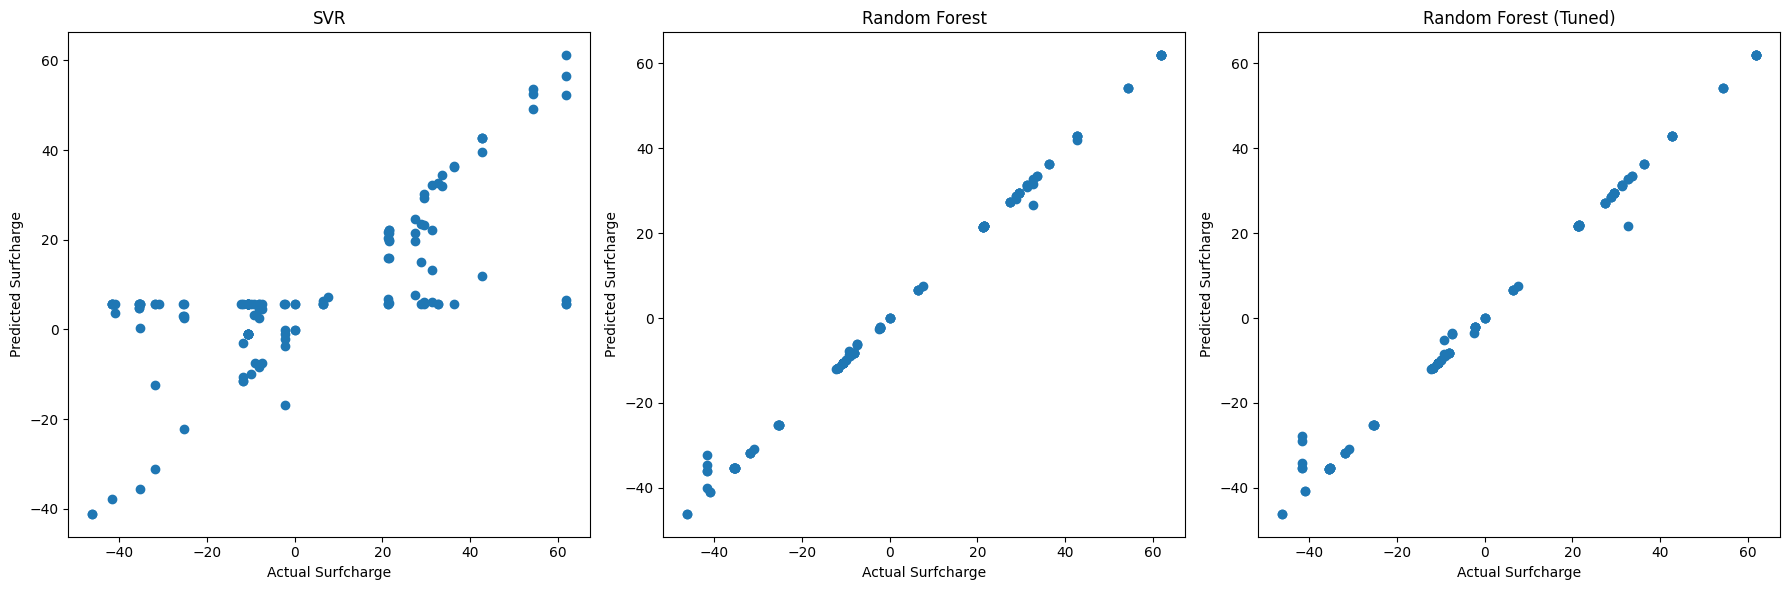

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(y_test, y_pred_svr)
axs[0].set_title('SVR')
axs[0].set_xlabel('Actual Surfcharge')
axs[0].set_ylabel('Predicted Surfcharge')

axs[1].scatter(y_test, y_pred_new_rf)
axs[1].set_title('Random Forest')
axs[1].set_xlabel('Actual Surfcharge')
axs[1].set_ylabel('Predicted Surfcharge')

axs[2].scatter(y_test, y_pred_rf_tuned)
axs[2].set_title('Random Forest (Tuned)')
axs[2].set_xlabel('Actual Surfcharge')
axs[2].set_ylabel('Predicted Surfcharge')

plt.tight_layout()
plt.show()

In [31]:
#попробуем попредсказывать значения coresize
df_core = df_cleaned_modified.drop(columns=['NPs'], axis = 1)
X = df_core.drop('coresize', axis=1)
y = df_core['coresize']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
svr_core_model = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_core_model.fit(X_train, y_train)
y_pred_core_svr = svr_core_model.predict(X_test)

In [33]:
rf_core_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_core_model.fit(X_train, y_train)
y_pred_core_rf = rf_core_model.predict(X_test)

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

grid_search_core = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_core.fit(X_train, y_train)
print("Best Parameters: ", grid_search_core.best_params_)
print("Best Score: ", grid_search_core.best_score_)

y_pred_rf_tuned_core = grid_search_core.predict(X_test)

Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score:  -0.7069779740524428


In [34]:
mse_core_svr = mean_squared_error(y_test, y_pred_core_svr)
r2_core_svr = r2_score(y_test, y_pred_core_svr)

mse_core_rf = mean_squared_error(y_test, y_pred_core_rf)
r2_core_rf = r2_score(y_test, y_pred_core_rf)

mse_core_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned_core)
r2_rf_tuned_core = r2_score(y_test, y_pred_rf_tuned_core)

print(f"SVR: MSE={mse_core_svr:.3f}, R²={r2_core_svr:.3f}")
print(f"Random Forest: MSE={mse_core_rf:.3f}, R²={r2_core_rf:.3f}")
print(f"Random Forest (Tuned): MSE={mse_core_rf_tuned:.3f}, R²={r2_rf_tuned_core:.3f}")

SVR: MSE=337.977, R²=0.521
Random Forest: MSE=0.205, R²=1.000
Random Forest (Tuned): MSE=0.181, R²=1.000


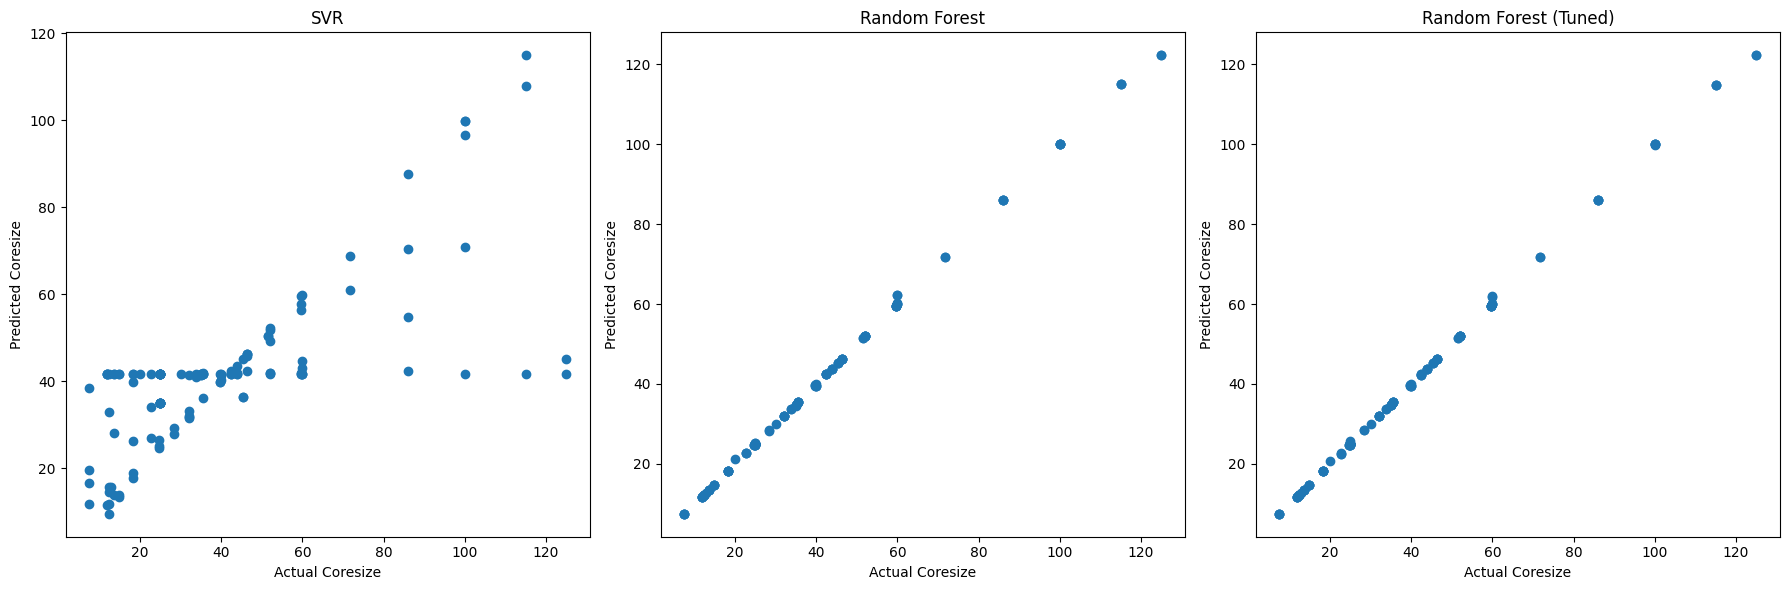

In [35]:
#Видим как модель отлично справляется со своей задачей
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(y_test, y_pred_core_svr)
axs[0].set_title('SVR')
axs[0].set_xlabel('Actual Coresize')
axs[0].set_ylabel('Predicted Coresize')

axs[1].scatter(y_test, y_pred_core_rf)
axs[1].set_title('Random Forest')
axs[1].set_xlabel('Actual Coresize')
axs[1].set_ylabel('Predicted Coresize')

axs[2].scatter(y_test, y_pred_rf_tuned_core)
axs[2].set_title('Random Forest (Tuned)')
axs[2].set_xlabel('Actual Coresize')
axs[2].set_ylabel('Predicted Coresize')

plt.tight_layout()
plt.show()